<a href="https://colab.research.google.com/github/pedrora22/XAI-test/blob/master/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importações:

In [ ]:
!pip install lime shap

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch as torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from captum.attr import IntegratedGradients, visualization as viz



import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

________________________________________________________________________________
# Criação de classes para o MLP (Multilayer Perceptron) e o CNN (Convolutional neural network)

Este módulo define duas arquiteturas de redes neurais usando PyTorch,
ambas projetadas para tarefas de classificação de imagens, como o dataset MNIST.

1.  MLP (Multi-Layer Perceptron):
    É uma rede neural densa (totalmente conectada) clássica. Ela processa
    as imagens achatando-as em um único vetor de 784 pixels (28*28)
    e o passa por três camadas lineares com funções de ativação ReLU
    nas camadas ocultas. É um modelo mais simples que não aproveita a
    estrutura espacial dos dados da imagem.

2.  SmallCNN (Small Convolutional Neural Network):
    É uma rede neural convolucional, mais adequada para tarefas de visão
    computacional. Ela utiliza duas camadas convolucionais (nn.Conv2d)
    intercaladas com camadas de max-pooling (nn.MaxPool2d) para extrair
    características espaciais da imagem de entrada. Após as camadas
    convolucionais, os mapas de características resultantes são achatados
    e passados para duas camadas lineares que realizam a classificação final.

Ambos os modelos produzem um tensor de saída com 10 valores (logits),
correspondendo às 10 classes do problema de classificação (por exemplo, os dígitos de 0 a 9).

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 10)


  def forward(self, x):
    x = x.view(-1, 28*28)
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    return self.fc3(x)


class SmallCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64*7*7, 128)
    self.fc2 = nn.Linear(128, 10)


  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(-1, 64*7*7)
    x = torch.relu(self.fc1(x))
    return self.fc2(x)

Esta seção do código é responsável por preparar e carregar o dataset MNIST,
deixando-o pronto para ser utilizado no treinamento e na avaliação dos modelos.

1.  **Transformação (transform):**
    É definida uma transformação simples que converte as imagens do formato PIL
    (Python Imaging Library) para tensores do PyTorch. Além disso, `transforms.ToTensor()`
    automaticamente normaliza os valores dos pixels, escalando-os do intervalo [0, 255]
    para o intervalo [0.0, 1.0].

2.  **Carregamento do Dataset (train_set, test_set):**
    O dataset MNIST é baixado (se ainda não estiver na pasta `./data`) e carregado
    em duas divisões: uma para treinamento (`train=True`) e outra para teste (`train=False`).
    A transformação definida anteriormente é aplicada a cada imagem no momento em
    que ela é carregada.

3.  **Criação dos DataLoaders (train_loader, test_loader):**
    Os `DataLoaders` são criados para carregar os dados em lotes (mini-batches),
    o que é essencial para treinar redes neurais de forma eficiente.
    - `train_loader`: Agrupa os dados de treino em lotes de 64 imagens e os embaralha
      a cada época (`shuffle=True`). O embaralhamento é crucial para que o modelo
      não aprenda com a ordem dos dados e generalize melhor.
    - `test_loader`: Agrupa os dados de teste em lotes de 1000. O embaralhamento
      não é necessário aqui, pois a ordem dos dados não afeta a avaliação.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])


train_set = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_set = datasets.MNIST("./data", train=False, download=True, transform=transform)


train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

Função para treinar e avaliar um modelo PyTorch.

Esta função encapsula um ciclo de treinamento padrão. Para cada época,
ela itera sobre todos os lotes de dados do 'train_loader', calcula a perda (loss),
realiza a retropropagação (backpropagation) para computar os gradientes e,
finalmente, atualiza os pesos do modelo com o otimizador.

Ao final de cada época de treinamento, a função entra em modo de avaliação
para medir a acurácia do modelo no conjunto de dados de teste, imprimindo o
resultado no console.

Processo detalhado:
1.  **Configuração Inicial:**
    - Detecta e seleciona o dispositivo disponível (GPU "cuda" ou "cpu").
    - Move o modelo para o dispositivo selecionado.
    - Define a função de perda `CrossEntropyLoss`, adequada para problemas de classificação.
    - Define o otimizador `Adam`, que irá ajustar os pesos do modelo.

2.  **Ciclo de Treinamento (por época):**
    - Ativa o modo de treino (`model.train()`), que habilita camadas como Dropout.
    - Itera sobre cada lote (batch) de dados do `train_loader`.
    - Zera os gradientes acumulados da iteração anterior (`optimizer.zero_grad()`).
    - Realiza a passada direta (forward pass) para obter as previsões do modelo.
    - Calcula a perda comparando as previsões com os rótulos verdadeiros.
    - Realiza a passada inversa (backward pass) para calcular os gradientes (`loss.backward()`).
    - Atualiza os pesos do modelo (`optimizer.step()`).

3.  **Ciclo de Avaliação (após cada época):**
    - Ativa o modo de avaliação (`model.eval()`), que desabilita camadas como Dropout.
    - Utiliza `torch.no_grad()` para desativar o cálculo de gradientes, economizando memória e acelerando o processo.
    - Itera sobre o `test_loader`, calcula a acurácia e imprime o resultado.

In [ ]:
def train(model, train_loader, test_loader, epochs=5):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)


  for epoch in range(epochs):
    model.train()
    for X, y in train_loader:
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      loss = criterion(model(X), y)
      loss.backward()
      optimizer.step()


  # Avaliação rápida
  model.eval()
  correct, total = 0, 0
  with torch.no_grad():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device)
      preds = model(X).argmax(1)
      correct += (preds == y).sum().item()
      total += y.size(0)
      print(f"Epoch {epoch+1}/{epochs} - Test Acc: {100*correct/total:.2f}%")


    return model

Esta é a seção principal que executa o treinamento e a preparação dos modelos.

O fluxo de trabalho é o seguinte:
1.  **Instanciação e Treinamento do MLP:**
    - Uma instância do modelo `MLP` é criada.
    - A função `train` é chamada para treinar o modelo MLP com os dados
      previamente carregados (`train_loader`, `test_loader`) por 5 épocas.
    - O modelo resultante, com os pesos ajustados, é salvo em `trained_model`.

2.  **Instanciação e Treinamento da CNN:**
    - O mesmo processo é repetido para o modelo `SmallCNN`. Uma nova instância
      é criada e treinada com os mesmos dados e pela mesma quantidade de épocas.
    - O modelo convolucional treinado é salvo em `trained_cnn_model`.

3.  **Preparação dos Modelos para Inferência:**
    - Os dois modelos treinados são movidos para o dispositivo de execução
      apropriado (GPU, se disponível, ou CPU).
    - Crucialmente, ambos os modelos são colocados em modo de avaliação
      usando `.eval()`. Isso é fundamental antes de fazer previsões, pois
      desativa camadas que se comportam de maneira diferente durante o
      treinamento e a inferência, como o Dropout e a Normalização em Lote
      (Batch Normalization), garantindo resultados consistentes.

Ao final da execução deste bloco, as variáveis `trained_model` e `trained_cnn_model`
contêm as versões finais e prontas para uso dos modelos.

In [ ]:
model = MLP()
trained_model = train(model, train_loader, test_loader, epochs=5)

cnn_model = SmallCNN()
trained_cnn_model = train(cnn_model, train_loader, test_loader, epochs=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
trained_cnn_model.to(device)

trained_model.eval()
trained_cnn_model.eval()


Epoch 5/5 - Test Acc: 97.50%
Epoch 5/5 - Test Acc: 96.70%
Epoch 5/5 - Test Acc: 96.63%
Epoch 5/5 - Test Acc: 96.83%
Epoch 5/5 - Test Acc: 96.78%
Epoch 5/5 - Test Acc: 96.97%
Epoch 5/5 - Test Acc: 97.13%
Epoch 5/5 - Test Acc: 97.36%
Epoch 5/5 - Test Acc: 97.52%
Epoch 5/5 - Test Acc: 97.57%
Epoch 5/5 - Test Acc: 98.90%
Epoch 5/5 - Test Acc: 98.25%
Epoch 5/5 - Test Acc: 98.23%
Epoch 5/5 - Test Acc: 98.33%
Epoch 5/5 - Test Acc: 98.34%
Epoch 5/5 - Test Acc: 98.53%
Epoch 5/5 - Test Acc: 98.60%
Epoch 5/5 - Test Acc: 98.78%
Epoch 5/5 - Test Acc: 98.90%
Epoch 5/5 - Test Acc: 98.90%


SmallCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

--- Running Failure Analysis ---
Found a misclassified image at index 61.
True Label: 8, MLP Prediction: 2


  0%|          | 0/1 [00:00<?, ?it/s]

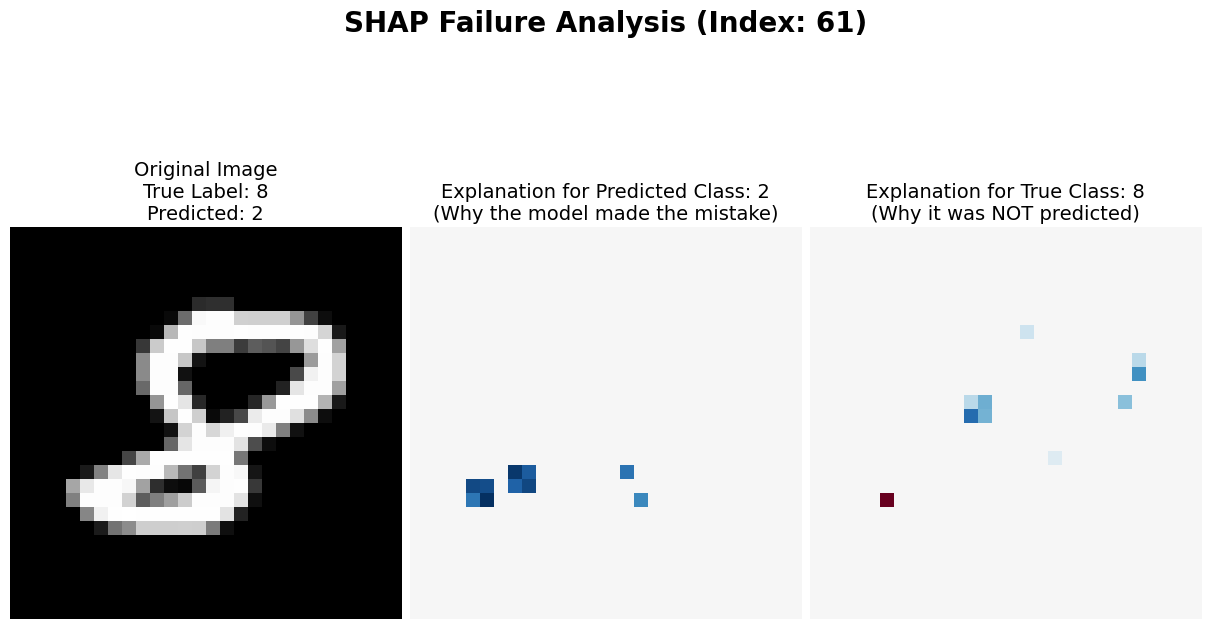

In [ ]:
# --- IDEIA 1: ANÁLISE DE CLASSIFICAÇÕES INCORRETAS (VERSÃO CORRIGIDA) ---

print("--- Running Failure Analysis ---")

# 1. Encontrar uma imagem classificada incorretamente pelo MLP
misclassified_img = None
misclassified_idx = -1

for i in range(len(test_set)):
    image, label = test_set[i]
    image_tensor = image.unsqueeze(0).to(device) # Adiciona dimensão de batch

    with torch.no_grad():
        output = trained_model(image_tensor)
        pred = output.argmax(dim=1).item()

    if pred != label:
        misclassified_img = image
        misclassified_label = label
        misclassified_pred = pred
        misclassified_idx = i
        print(f"Found a misclassified image at index {i}.")
        print(f"True Label: {label}, MLP Prediction: {pred}")
        break

# 2. Gerar a explicação SHAP para a imagem incorreta
if misclassified_img is not None:
    # --- Bloco de setup do SHAP (necessário aqui para garantir que temos o explicador certo) ---
    # Função de predição para o SHAP (usando o MLP)
    def predict_np(x):
        x_t = torch.tensor(x).float().to(device)
        with torch.no_grad():
            out = trained_model(x_t) # Usando o trained_model (MLP)
        return torch.softmax(out, dim=1).cpu().numpy()

    # Background para o explainer
    background = np.stack([test_set[i][0].numpy().flatten() for i in range(20)])

    # Criar o explicador SHAP com um nome único
    shap_explainer = shap.KernelExplainer(predict_np, background)
    # --- Fim do Bloco de setup do SHAP ---

    image_np_mis = misclassified_img.numpy().squeeze()
    image_vector_mis = image_np_mis.flatten()

    # Usar o explicador SHAP correto
    shap_values_mis = shap_explainer.shap_values(image_vector_mis.reshape(1, -1))

    # Reformatar os valores SHAP para plotagem
    shap_values_for_plot_mis = shap_values_mis[0].T.reshape(-1, 28, 28)

    # 3. Gerar o Dashboard de Análise de Falha
    probabilities_mis = predict_np(image_vector_mis.reshape(1, -1))[0]

    # Classes de interesse: a predição (incorreta) e o rótulo (correto)
    pred_class_mis = misclassified_pred
    true_class_mis = misclassified_label

    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    fig.suptitle(f'SHAP Failure Analysis (Index: {misclassified_idx})', fontsize=20, weight='bold')
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

    # Plot 1: Imagem Original
    ax_orig = fig.add_subplot(spec[0, 0])
    ax_orig.imshow(image_np_mis, cmap='gray')
    ax_orig.set_title(f'Original Image\nTrue Label: {true_class_mis}\nPredicted: {pred_class_mis}', fontsize=14)
    ax_orig.axis('off')

    # Plot 2: Explicação para a Classe PREDITA (Incorreta)
    ax_pred = fig.add_subplot(spec[0, 1])
    vmax = np.abs(shap_values_for_plot_mis[pred_class_mis]).max()
    ax_pred.imshow(shap_values_for_plot_mis[pred_class_mis], cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax_pred.set_title(f'Explanation for Predicted Class: {pred_class_mis}\n(Why the model made the mistake)', fontsize=14)
    ax_pred.axis('off')

    # Plot 3: Explicação para a Classe CORRETA
    ax_true = fig.add_subplot(spec[0, 2])
    vmax = np.abs(shap_values_for_plot_mis[true_class_mis]).max()
    ax_true.imshow(shap_values_for_plot_mis[true_class_mis], cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax_true.set_title(f'Explanation for True Class: {true_class_mis}\n(Why it was NOT predicted)', fontsize=14)
    ax_true.axis('off')

    plt.show()
else:
    print("No misclassified images found in the first batch. Try increasing the search range.")

A razão principal para este resultado não está em um erro do SHAP, mas sim na ambiguidade da imagem original. O que temos é um dígito "4" muito mal escrito, cujo topo está fechado, fazendo-o se parecer enormemente com um "9". O modelo ficou confuso, e o SHAP nos mostra visualmente essa confusão.

Vamos analisar cada painel:

1. Painel Esquerdo (A Imagem Original)
Rótulo Verdadeiro: 4

Previsão do Modelo: 9

Observação Humana: Podemos ver imediatamente por que o modelo errou. O "laço" fechado no topo é a característica mais forte da imagem, e essa é uma característica de um "9", não de um "4". O modelo foi "enganado" por uma característica visualmente dominante.

2. Painel do Meio (Explicação para a Classe Predita: 9)
Título: "Por que o modelo cometeu o erro".

Análise do SHAP: Este é o painel mais interessante e contraintuitivo. Lembre-se que no nosso plot:

Vermelho = Evidência A FAVOR da classe.

Azul = Evidência CONTRA a classe.

O que vemos aqui? Apenas pixels azuis. Não há pixels vermelhos.

O que isso significa? Isso é fascinante. Significa que, embora o modelo tenha previsto "9", nenhum pixel da imagem deu uma contribuição positiva forte para essa decisão. O modelo escolheu "9" não porque viu fortes evidências de um "9", mas porque essa foi a opção "menos pior" entre todas as outras.

A previsão final do modelo é baseada nos "logits" (a saída antes da camada softmax). O que provavelmente aconteceu foi que os logits para todas as classes eram negativos, mas o logit para a classe "9" era o menos negativo (ex: -1.5 para a classe 9, -2.8 para a classe 4, -5.0 para a classe 1, etc.).

Em suma, este painel nos diz: "O modelo apostou em '9' com baixíssima confiança, e os pixels da imagem na verdade argumentaram contra essa decisão, apenas com menos força do que argumentaram contra as outras classes."

3. Painel da Direita (Explicação para a Classe Verdadeira: 4)
Título: "Por que NÃO foi previsto".

Análise do SHAP: Este painel mostra por que o modelo rejeitou o rótulo correto, "4". Aqui, a interpretação é direta.

O que vemos? Vemos pixels azuis concentrados exatamente na área problemática: o topo fechado do dígito.

O que isso significa? SHAP está nos dizendo explicitamente: "Esta região (o laço fechado) é uma forte evidência CONTRA a imagem ser um '4'. Um '4' deveria ter um topo aberto, e como essa imagem não tem, eu diminuí a pontuação para a classe '4'."

Conclusão e Como Usar Isso no seu Artigo
Este é um resultado de ouro. O SHAP não está errado; ele está funcionando perfeitamente e revelando a "luta" interna do modelo.

No seu artigo, você pode usar esta imagem para argumentar que:

XAI é uma poderosa ferramenta de depuração: Ele permite identificar exatamente qual característica de uma imagem levou a uma falha de classificação.

XAI revela a confiança do modelo: A ausência de evidências positivas (pixels vermelhos) para a classe prevista é um forte indicador de que a decisão foi uma aposta de baixa confiança.

A análise vai além do acerto/erro: Mostra a capacidade do XAI de lidar com casos ambíguos, que são comuns em problemas do mundo real, e explicar por que o modelo ficou "em dúvida".

_________________________________________________________________________

--- Análise de Confiança para a Imagem no Índice 96 ---
Rótulo Verdadeiro: 1
Previsão do Modelo: 1
Confiança na Previsão Incorreta ('1'): 84.90%
Probabilidade atribuída à Classe Correta ('1'): 84.90%


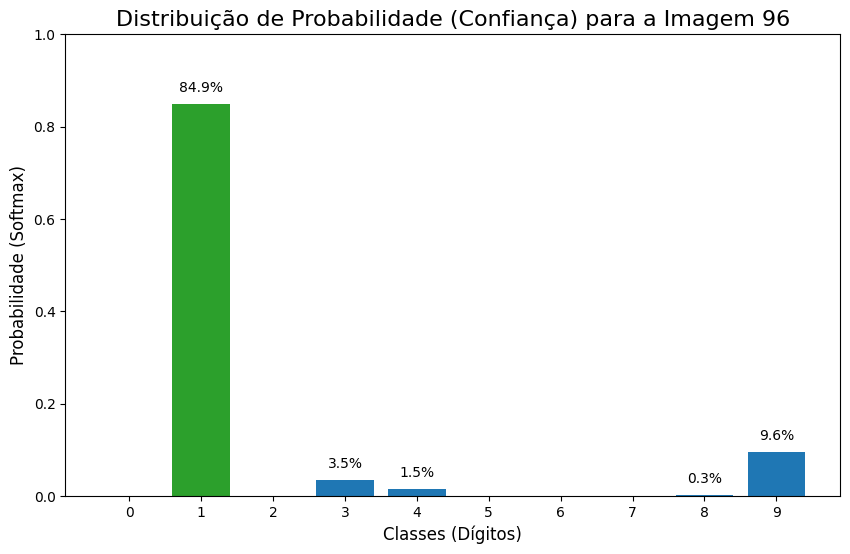

In [ ]:
# --- AFERINDO A CONFIANÇA DO MODELO PARA A IMAGEM INCORRETA (ÍNDICE 115) ---

# 1. Pegar a imagem e o rótulo do índice 115
i = 96
image, label = test_set[i]
image_np = image.numpy().squeeze()
image_vector = image_np.flatten()

# 2. Obter o vetor de probabilidades usando a sua função
# A função predict_np já usa o modelo MLP (trained_model)
probabilities = predict_np(image_vector.reshape(1, -1))[0]
pred_class = np.argmax(probabilities)
confidence = probabilities[pred_class]
true_label_prob = probabilities[label]

print(f"--- Análise de Confiança para a Imagem no Índice {i} ---")
print(f"Rótulo Verdadeiro: {label}")
print(f"Previsão do Modelo: {pred_class}")
print(f"Confiança na Previsão Incorreta ('{pred_class}'): {confidence:.2%}")
print(f"Probabilidade atribuída à Classe Correta ('{label}'): {true_label_prob:.2%}")


# 3. Gerar o Gráfico de Barras para Visualizar a Confiança
fig, ax = plt.subplots(figsize=(10, 6))

classes = np.arange(10)
colors = ['#1f77b4'] * 10  # Cor padrão
colors[pred_class] = '#d62728' # Vermelho para a predição incorreta
colors[label] = '#2ca02c'      # Verde para o rótulo verdadeiro

bars = ax.bar(classes, probabilities, color=colors)

ax.set_title(f'Distribuição de Probabilidade (Confiança) para a Imagem {i}', fontsize=16)
ax.set_xlabel('Classes (Dígitos)', fontsize=12)
ax.set_ylabel('Probabilidade (Softmax)', fontsize=12)
ax.set_xticks(classes)
ax.set_ylim(0, 1)

# Adicionar o valor da probabilidade em cima de cada barra
for bar in bars:
    yval = bar.get_height()
    if yval > 0.001: # Só mostra se for minimamente relevante
      ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.1%}', ha='center', va='bottom')

plt.show()

Análise de Interpretabilidade do Modelo com LIME

Este script utiliza a biblioteca LIME (Local Interpretable Model-agnostic Explanations)
para gerar uma explicação visual sobre quais partes de uma imagem de teste foram mais
importantes para a decisão do modelo `trained_model`. LIME é uma técnica
agnóstica a modelos que ajuda a entender o porquê de uma previsão específica.

O processo é dividido nas seguintes etapas:

1.  **Preparação:**
    - O modelo treinado é colocado em modo de avaliação (`.eval()`).
    - Uma imagem específica (a de índice `i`) é selecionada do conjunto de teste.
    - A imagem, que é um tensor PyTorch, é convertida para um array NumPy e
      suas dimensões são ajustadas (`.squeeze()`) para o formato que a
      biblioteca LIME espera.

2.  **Função de Predição (`predict_fn`):**
    - LIME funciona gerando milhares de variações (perturbações) da imagem
      original. Ele precisa de uma função que possa receber esses novos dados
      (como arrays NumPy) e retornar as previsões do modelo no formato de
      probabilidades.
    - A `predict_fn` serve como uma "ponte" entre o LIME e nosso modelo PyTorch.
      Ela realiza todo o pré-processamento necessário:
        - Converte os arrays NumPy em tensores PyTorch.
        - Ajusta as dimensões para o padrão do modelo (batch, canais, altura, largura).
        - Normaliza os valores dos pixels.
        - Move os dados para o dispositivo correto (GPU/CPU).
        - Passa os dados pelo modelo, aplica a função `softmax` para obter as
          probabilidades de cada classe e retorna o resultado como um array NumPy.

3.  **Execução e Visualização do LIME:**
    - O `LimeImageExplainer` é instanciado.
    - A função `explain_instance` é chamada, passando a imagem original e a
      nossa função de predição. O LIME gera as perturbações, coleta as
      previsões e constrói um modelo linear local para explicar a decisão.
    - O resultado (`explanation`) contém uma máscara que indica as "superpixels"
      (regiões da imagem) que mais contribuíram positivamente para a previsão.
    - Por fim, a imagem original é exibida com essas regiões importantes
      destacadas, fornecendo uma interpretação visual clara da decisão do modelo.

  0%|          | 0/1000 [00:00<?, ?it/s]

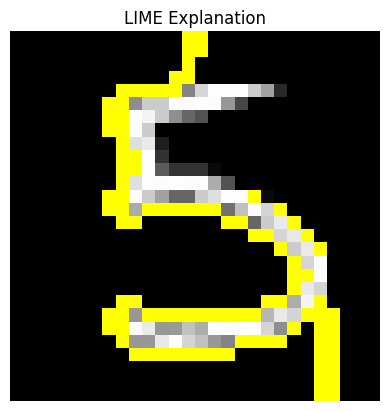

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.eval()


# Pegar exemplo
i = 15
image, label = test_set[i]
image_np = image.numpy().squeeze()


# Função de predição para LIME
def predict_fn(images):
    import numpy as np
    import torch

    imgs = np.array(images)  # (N,H,W,3) ou (H,W,3) do LIME

    # Se vier com 3 canais (RGB), convertemos para grayscale
    if imgs.ndim == 4 and imgs.shape[-1] == 3:
        imgs = imgs.mean(axis=-1)  # (N,H,W)

    # Se for uma única imagem, adiciona batch
    if imgs.ndim == 2:  # (H,W)
        imgs = np.expand_dims(imgs, 0)  # (1,H,W)
    elif imgs.ndim == 3 and imgs.shape[0] != len(images):  # LIME às vezes passa (H,W,C)
        imgs = np.expand_dims(imgs, 0)  # (1,H,W)

    # Converte para float e normaliza
    imgs = imgs.astype(np.float32)
    if imgs.max() > 1.0:
        imgs = imgs / 255.0

    # Para PyTorch: (batch, channels=1, H, W)
    tensor = torch.tensor(imgs).unsqueeze(1).to(device)  # N,H,W -> N,1,H,W

    with torch.no_grad():
        outputs = trained_model(tensor)

    return torch.softmax(outputs, dim=1).cpu().numpy()


# Rodar LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
image_np,
predict_fn,
top_labels=1,
hide_color=0,
num_samples=1000
)


lime_img, mask = explanation.get_image_and_mask(
explanation.top_labels[0],
positive_only=True,
hide_rest=False
)


plt.imshow(mark_boundaries(lime_img, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()

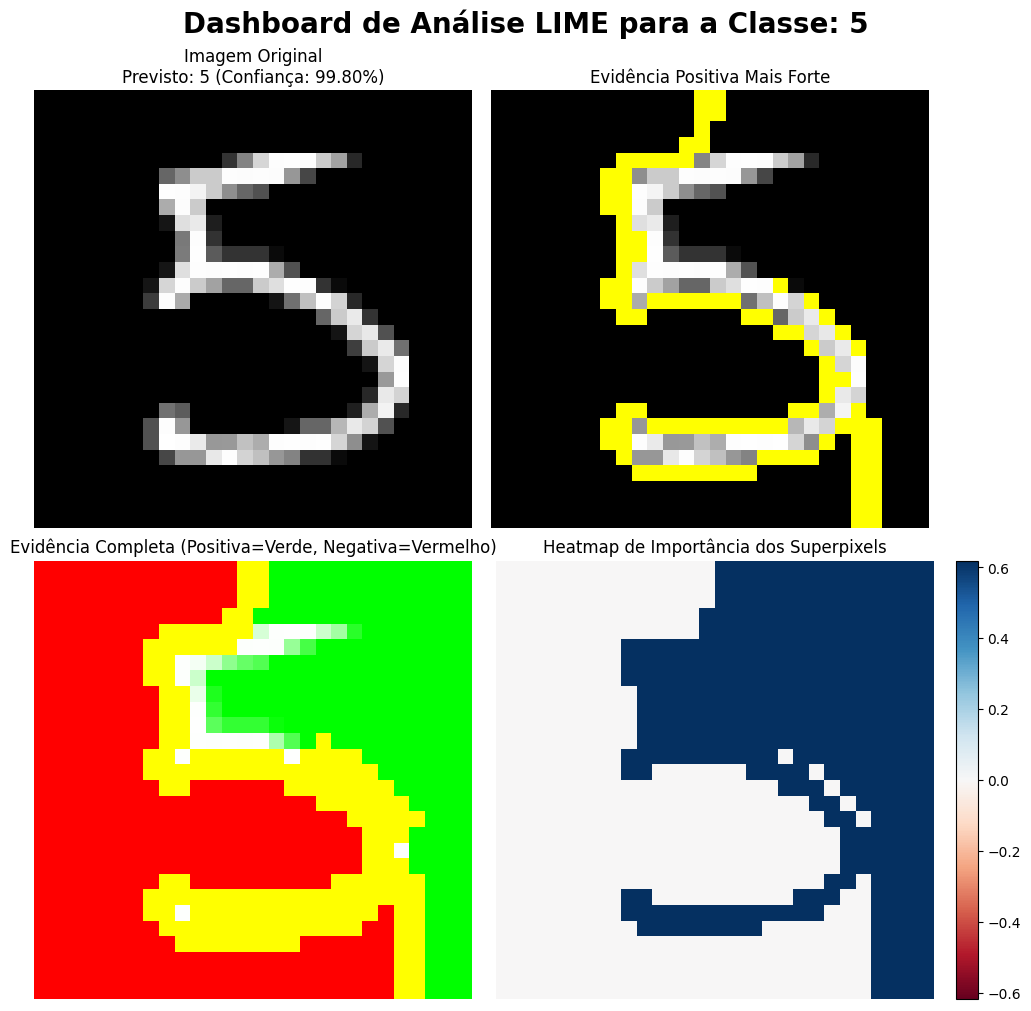

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import numpy as np

# --- Assumindo que você já rodou o LIME e tem a variável 'explanation' ---

# 1. Obter informações da previsão
# O LIME já calcula isso, então podemos pegar diretamente do objeto 'explanation'
pred_class = explanation.top_labels[0]
probabilities = predict_fn(image_np.reshape(1, 28, 28, 1))[0] # LIME às vezes precisa de 4D
pred_prob = probabilities[pred_class]

# --- Início da Criação do Dashboard ---

# 2. Configurar a figura
fig, ax = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
fig.suptitle(f'Dashboard de Análise LIME para a Classe: {pred_class}', fontsize=20, weight='bold')

# 3. Plot 1: Imagem Original
ax[0, 0].imshow(image_np, cmap='gray')
ax[0, 0].set_title(f'Imagem Original\nPrevisto: {pred_class} (Confiança: {pred_prob:.2%})', fontsize=12)
ax[0, 0].axis('off')

# 4. Plot 2: Evidência Apenas Positiva (com o resto oculto)
lime_img_pos, mask_pos = explanation.get_image_and_mask(
    pred_class,
    positive_only=True,
    hide_rest=True, # Esconde o que não é importante
    num_features=5 # Mostra os 5 superpixels mais importantes
)
ax[0, 1].imshow(mark_boundaries(lime_img_pos, mask_pos))
ax[0, 1].set_title('Evidência Positiva Mais Forte', fontsize=12)
ax[0, 1].axis('off')

# 5. Plot 3: Evidência Completa (Positiva e Negativa)
lime_img_all, mask_all = explanation.get_image_and_mask(
    pred_class,
    positive_only=False, # Mostra evidência positiva e negativa
    hide_rest=False,
    num_features=10
)
ax[1, 0].imshow(mark_boundaries(lime_img_all, mask_all))
ax[1, 0].set_title('Evidência Completa (Positiva=Verde, Negativa=Vermelho)', fontsize=12)
ax[1, 0].axis('off')

# 6. Plot 4: Heatmap de Importância dos Superpixels
# Cria um mapa de calor vazio
heatmap = np.zeros(explanation.segments.shape)
# Pega os pesos de cada superpixel para a classe predita
weights = explanation.local_exp[pred_class]
# Preenche o mapa de calor com os pesos
for f, w in weights:
    heatmap[explanation.segments == f] = w

# Plota o heatmap
vmax = np.abs(heatmap).max()
im = ax[1, 1].imshow(heatmap, cmap='RdBu', vmin=-vmax, vmax=vmax)
ax[1, 1].set_title('Heatmap de Importância dos Superpixels', fontsize=12)
ax[1, 1].axis('off')
fig.colorbar(im, ax=ax[1, 1])


plt.show()

Análise de Interpretabilidade do Modelo com SHAP.

Este script emprega a biblioteca SHAP (SHapley Additive exPlanations) para
quantificar a contribuição de cada pixel na imagem para a predição do modelo
treinado (`trained_model`). SHAP oferece uma abordagem baseada na teoria dos jogos
para explicar as saídas de qualquer modelo de machine learning, fornecendo
garantias teóricas de consistência.

O processo é dividido nas seguintes etapas:

1.  **Preparação dos Dados:**
    - A imagem de interesse é achatada (`flatten`) em um vetor unidimensional (784 pixels),
      pois o `KernelExplainer` do SHAP opera sobre dados nesse formato tabular/vetorial.
    - Um `background` (conjunto de dados de fundo) é criado a partir de um
      subconjunto de 20 imagens do conjunto de teste. Este `background` é crucial
      para o SHAP, pois ele é usado como referência para simular a "ausência"
      de um pixel (substituindo-o por valores da distribuição de fundo), permitindo
      assim calcular sua contribuição real para a predição.

2.  **Função de Predição (`predict_np`):**
    - Assim como no LIME, uma função adaptadora é necessária para que o SHAP,
      que trabalha com NumPy, possa interagir com o modelo PyTorch.
    - Esta função recebe um lote de vetores de imagem (NumPy arrays), converte-os
      para tensores PyTorch, passa-os pelo modelo e retorna as probabilidades
      resultantes (via softmax) como um NumPy array.

3.  **Cálculo dos Valores SHAP:**
    - Um `shap.KernelExplainer` é inicializado com a função de predição e o
      conjunto de dados de fundo.
    - O método `explainer.shap_values()` é chamado para calcular os valores SHAP
      para a imagem de interesse. O resultado é a contribuição de cada um dos 784 pixels
      para a pontuação de saída de *cada uma das 10 classes*.

4.  **Remodelagem e Visualização:**
    - A saída do `explainer` pode vir em diferentes formatos. O código lida com isso,
      garantindo que os valores SHAP sejam remodelados para um formato visualizável:
      uma matriz 28x28 (a imagem original) para cada uma das 10 classes.
    - A função `shap.image_plot` é utilizada para criar uma visualização rica.
      Ela exibe a imagem original e, para cada classe (de 0 a 9), plota os valores SHAP
      correspondentes. Pixels em vermelho são evidências que *aumentam* a
      probabilidade daquela classe, enquanto pixels em azul são evidências que
      a *diminuem*. Isso permite entender não apenas por que o modelo escolheu a classe
      correta, mas também por que ele descartou as outras.

  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
1
(1, 784, 10)


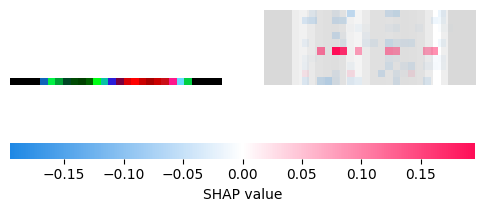

In [ ]:
import shap
import torch
import numpy as np

# Flatten a imagem e background
image_vector = image_np.flatten()  # 784
background = np.stack([test_set[i][0].numpy().flatten() for i in range(20)])  # (20,784)

# Função de predição
def predict_np(x):
    x_t = torch.tensor(x).float().to(device)
    with torch.no_grad():
        out = trained_model(x_t)
    return torch.softmax(out, dim=1).cpu().numpy()

# KernelExplainer
explainer = shap.KernelExplainer(predict_np, background)

# SHAP values para 1 imagem
shap_values = explainer.shap_values(image_vector.reshape(1,-1))

# Verificando o tipo retornado
print(type(shap_values))
print(len(shap_values))
print(np.array(shap_values).shape)

# Se for uma lista de arrays (uma por classe) - este formato é menos comum com KernelExplainer
if isinstance(shap_values, list):
    # Pega a classe prevista pelo modelo
    pred_class = np.argmax(predict_np(image_vector.reshape(1, -1)))
    shap_values_for_plot = [val.reshape(28, 28) for val in shap_values]

# Se for um único array 3D (formato que você está recebendo)
else:
    # O shape é (1, 784, 10), precisamos ajustar para o formato que image_plot espera
    # Trocamos os eixos de features (784) e classes (10) para (1, 10, 784)
    # E então remodelamos cada explicação de classe para (28, 28)
    shap_values_for_plot = shap_values[0].T.reshape(-1, 28, 28)

# Plot
# A imagem original deve ter o formato (amostras, altura, largura)
shap.image_plot(shap_values_for_plot, image_np.reshape(1, 28, 28))


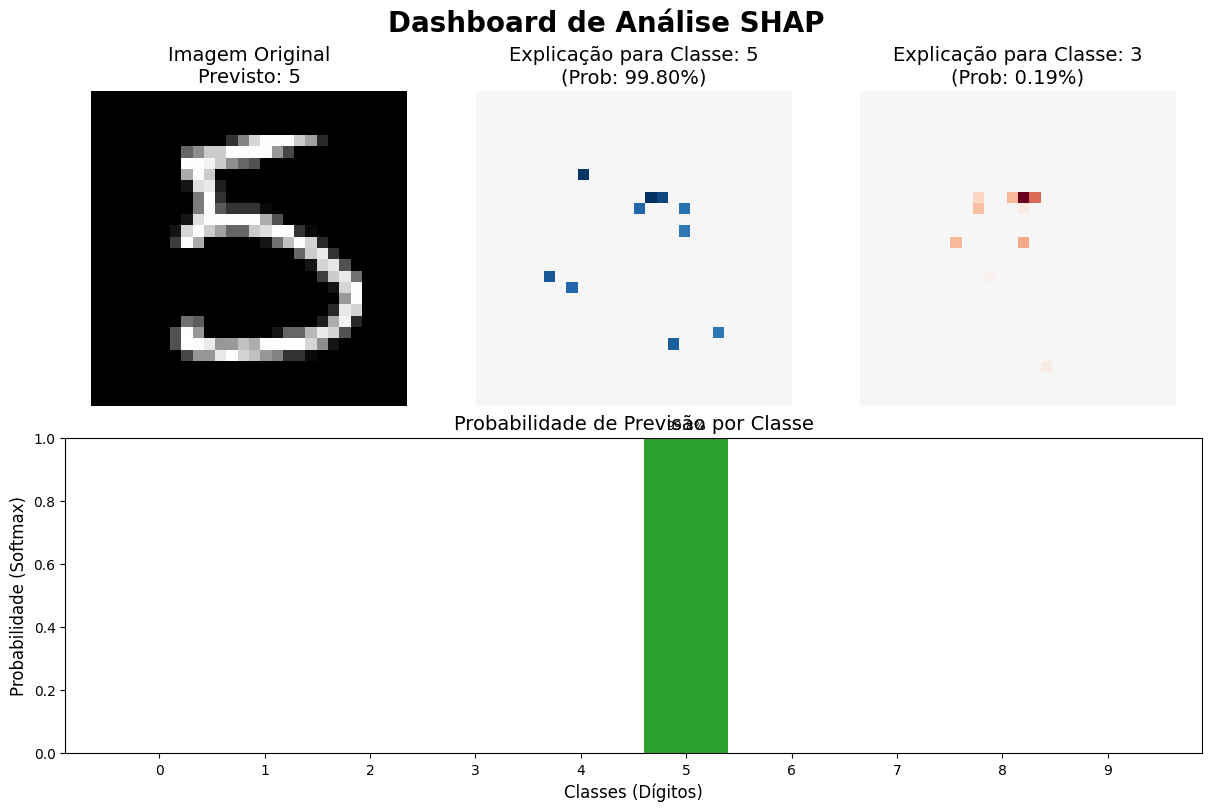

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# 1. Obter as previsões do modelo para a imagem
# A função predict_np retorna um array de probabilidades com shape (1, 10)
# Pegamos o primeiro (e único) elemento para ter um array 1D de 10 posições
probabilities = predict_np(image_vector.reshape(1, -1))[0]

# 2. Encontrar as duas classes com maior probabilidade
# argsort retorna os índices do menor para o maior, então pegamos os dois últimos com [::-1]
top_classes_indices = np.argsort(probabilities)[::-1]
pred_class = top_classes_indices[0]
pred_prob = probabilities[pred_class]
second_pred_class = top_classes_indices[1]
second_pred_prob = probabilities[second_pred_class]

# --- Início da Criação do Dashboard ---

# 3. Configurar a figura e a grade de plots
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

# Definindo os locais de cada subplot
ax_orig = fig.add_subplot(spec[0, 0])
ax_pred = fig.add_subplot(spec[0, 1])
ax_second = fig.add_subplot(spec[0, 2])
ax_bar = fig.add_subplot(spec[1, :]) # Ocupa a linha inteira de baixo

fig.suptitle('Dashboard de Análise SHAP', fontsize=20, weight='bold')

# 4. Plot da Imagem Original
ax_orig.imshow(image_np, cmap='gray')
ax_orig.set_title(f'Imagem Original\nPrevisto: {pred_class}', fontsize=14)
ax_orig.axis('off')

# 5. Plot da Explicação para a Classe Prevista
# shap_values_for_plot tem shape (10, 28, 28)
explanation_pred = shap_values_for_plot[pred_class]
# Normalizamos os valores para melhorar o contraste do plot
vmax = np.abs(explanation_pred).max()
im1 = ax_pred.imshow(explanation_pred, cmap='RdBu', vmin=-vmax, vmax=vmax)
ax_pred.set_title(f'Explicação para Classe: {pred_class}\n(Prob: {pred_prob:.2%})', fontsize=14)
ax_pred.axis('off')

# 6. Plot da Explicação para a Segunda Classe Mais Provável
explanation_second = shap_values_for_plot[second_pred_class]
vmax = np.abs(explanation_second).max()
im2 = ax_second.imshow(explanation_second, cmap='RdBu', vmin=-vmax, vmax=vmax)
ax_second.set_title(f'Explicação para Classe: {second_pred_class}\n(Prob: {second_pred_prob:.2%})', fontsize=14)
ax_second.axis('off')

# 7. Plot do Gráfico de Barras com as Probabilidades
classes = np.arange(10)
colors = ['#1f77b4'] * 10
colors[pred_class] = '#2ca02c' # Verde para a classe predita
colors[second_pred_class] = '#ff7f0e' # Laranja para a segunda
ax_bar.bar(classes, probabilities, color=colors)
ax_bar.set_title('Probabilidade de Previsão por Classe', fontsize=14)
ax_bar.set_xlabel('Classes (Dígitos)', fontsize=12)
ax_bar.set_ylabel('Probabilidade (Softmax)', fontsize=12)
ax_bar.set_xticks(classes)
ax_bar.set_ylim(0, 1)

# Adicionar o valor da probabilidade em cima de cada barra
for index, value in enumerate(probabilities):
    if value > 0.01:
        ax_bar.text(index, value + 0.02, f"{value:.1%}", ha='center', va='bottom', fontsize=9)


plt.show()


--- Step 4: Running Model Comparison (MLP vs. CNN) using LIME ---
Setting up LIME explainer...
Generating LIME explanation for MLP (this may take a minute)...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating LIME explanation for CNN...


  0%|          | 0/1000 [00:00<?, ?it/s]

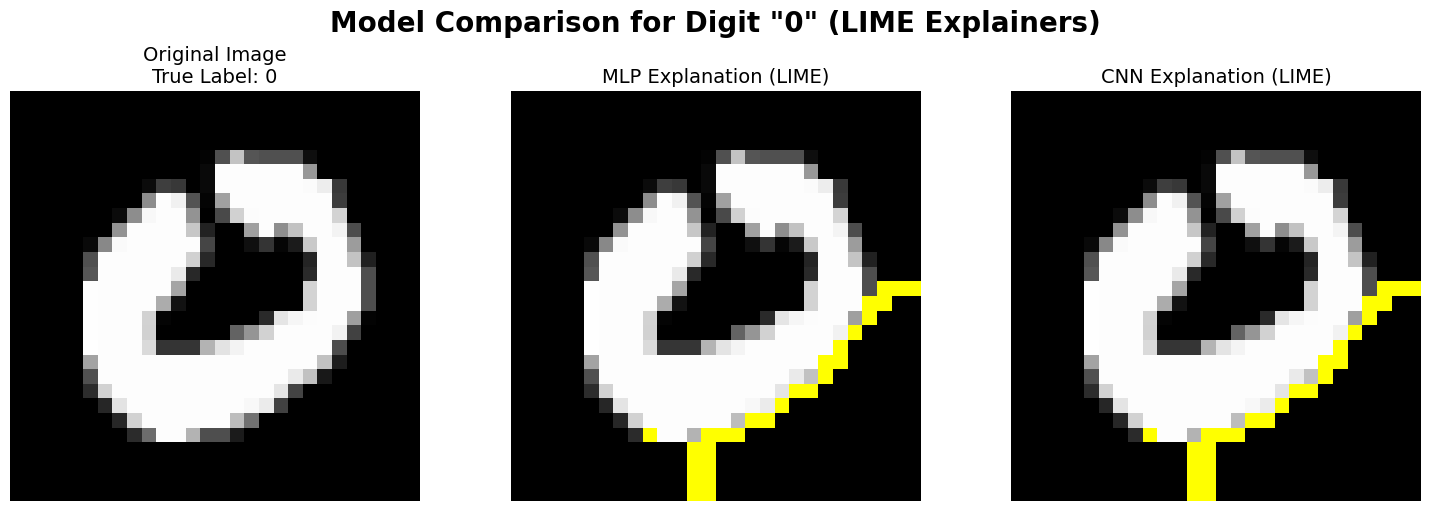

In [ ]:
# ================================================================
# 5. ANÁLISE COMPARATIVA COM LIME
# ================================================================
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Step 4: Running Model Comparison (MLP vs. CNN) using LIME ---")

# Escolher uma imagem para análise
i = 25
image, label = test_set[i]
# LIME precisa de uma imagem que se pareça com uma imagem colorida (H, W, C)
# Então, vamos duplicar o canal cinza para criar um array (28, 28, 3)
image_np_rgb = np.stack([image.numpy().squeeze()] * 3, axis=-1)

# ================================================================
# --- 1. Funções de predição para o LIME ---
# ================================================================

# LIME envia imagens como numpy arrays (N, H, W, C).
# Nossas funções precisam converter isso para o formato que cada modelo espera.

def predict_mlp_lime_fn(images):
    # Converte para tons de cinza e achata o vetor para o MLP
    images_gray = images.mean(axis=-1) # (N, H, W, 3) -> (N, H, W)
    images_flat = images_gray.reshape(images_gray.shape[0], -1) # (N, H, W) -> (N, 784)

    # Converte para tensor e passa pelo modelo MLP
    tensor = torch.tensor(images_flat).float().to(device)
    with torch.no_grad():
        outputs = trained_model(tensor)
    return torch.softmax(outputs, dim=1).cpu().numpy()

def predict_cnn_lime_fn(images):
    # Converte para o formato que a CNN espera: (N, C, H, W)
    # Pega apenas um canal (pois são tons de cinza) e transpõe os eixos
    images_torch = torch.tensor(images[:, :, :, 0]).unsqueeze(1).float().to(device)

    with torch.no_grad():
        outputs = trained_cnn_model(images_torch)
    return torch.softmax(outputs, dim=1).cpu().numpy()

# ================================================================
# --- 2. Geração das Explicações LIME ---
# ================================================================
print("Setting up LIME explainer...")
explainer_lime = lime_image.LimeImageExplainer()

print("Generating LIME explanation for MLP (this may take a minute)...")
explanation_mlp = explainer_lime.explain_instance(
    image_np_rgb,
    predict_mlp_lime_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000 # Número de amostras para gerar a explicação
)

print("Generating LIME explanation for CNN...")
explanation_cnn = explainer_lime.explain_instance(
    image_np_rgb,
    predict_cnn_lime_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# ================================================================
# --- 3. Preparação das visualizações ---
# ================================================================
# Pega a máscara de superpixels que são evidência A FAVOR da predição
img_mlp, mask_mlp = explanation_mlp.get_image_and_mask(
    explanation_mlp.top_labels[0],
    positive_only=True,
    hide_rest=False, # Não esconde o resto da imagem
    num_features=5     # Destaca os 5 superpixels mais importantes
)

img_cnn, mask_cnn = explanation_cnn.get_image_and_mask(
    explanation_cnn.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=5
)

# ================================================================
# --- 4. Visualização comparativa ---
# ================================================================
fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
fig.suptitle(f'Model Comparison for Digit "{label}" (LIME Explainers)', fontsize=20, weight='bold')

# Imagem original
ax[0].imshow(image.numpy().squeeze(), cmap='gray')
ax[0].set_title(f'Original Image\nTrue Label: {label}', fontsize=14)
ax[0].axis('off')

# MLP Explanation
# mark_boundaries desenha o contorno verde nos superpixels importantes
ax[1].imshow(mark_boundaries(img_mlp, mask_mlp))
ax[1].set_title(f'MLP Explanation (LIME)', fontsize=14)
ax[1].axis('off')

# CNN Explanation
ax[2].imshow(mark_boundaries(img_cnn, mask_cnn))
ax[2].set_title(f'CNN Explanation (LIME)', fontsize=14)
ax[2].axis('off')

plt.show()


--- Step 4: Running Model Comparison (MLP vs. CNN) using Captum ---
Setting up Integrated Gradients for MLP...
Generating attributions for MLP...

Setting up Integrated Gradients for CNN...
Generating attributions for CNN...

Generating comparison plot...


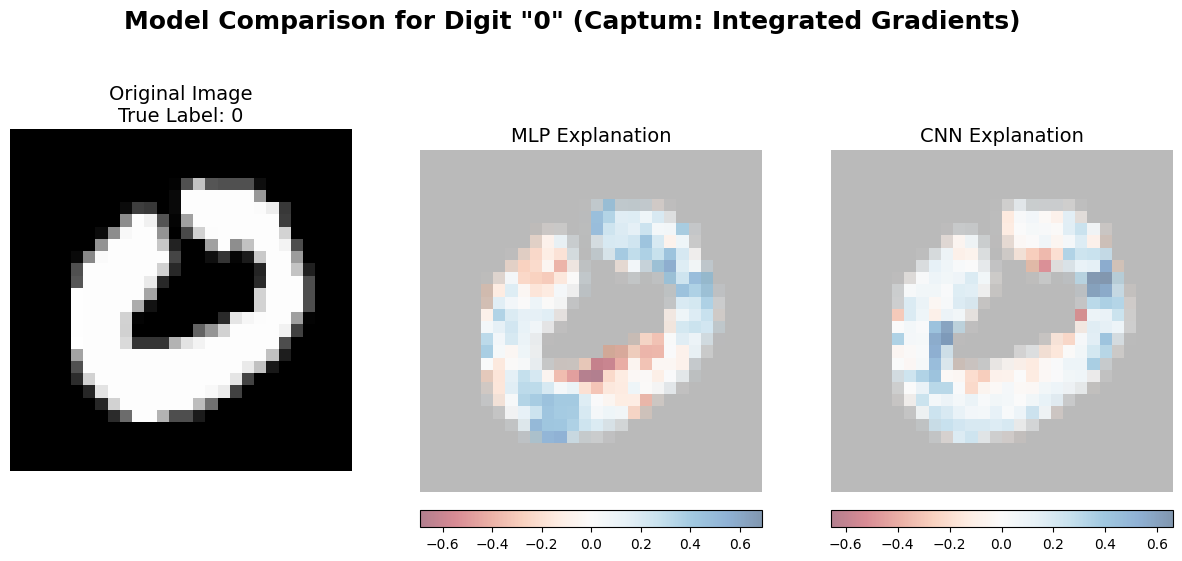

In [ ]:
# ================================================================
# 5. ANÁLISE COMPARATIVA COM CAPTUM (VISUALIZAÇÃO CORRIGIDA)
# ================================================================
try:
    import captum
except ImportError:
    print("Installing captum...")
    !pip install captum

from captum.attr import IntegratedGradients, visualization as viz
import torch
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Step 4: Running Model Comparison (MLP vs. CNN) using Captum ---")

# Escolher uma imagem para análise
i = 25
image, label = test_set[i]
image_np = image.numpy().squeeze()

# --- Preparação dos dados para o Captum ---
input_mlp = image.flatten().unsqueeze(0).to(device)
input_cnn = image.unsqueeze(0).to(device)
baseline_mlp = torch.zeros_like(input_mlp)
baseline_cnn = torch.zeros_like(input_cnn)

# --- 1. Explicador para o MLP: Usando Integrated Gradients ---
print("Setting up Integrated Gradients for MLP...")
ig_mlp = IntegratedGradients(trained_model)
print("Generating attributions for MLP...")
attribution_mlp = ig_mlp.attribute(input_mlp, baselines=baseline_mlp, target=label)
attribution_mlp_np = attribution_mlp.squeeze().cpu().detach().numpy().reshape(28, 28)

# --- 2. Explicador para a CNN: Usando Integrated Gradients ---
print("\nSetting up Integrated Gradients for CNN...")
ig_cnn = IntegratedGradients(trained_cnn_model)
print("Generating attributions for CNN...")
attribution_cnn = ig_cnn.attribute(input_cnn, baselines=baseline_cnn, target=label)
attribution_cnn_np = attribution_cnn.squeeze().cpu().detach().numpy()

# ================================================================
# --- 3. Visualização comparativa MANUAL e CORRIGIDA ---
# ================================================================
print("\nGenerating comparison plot...")
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle(f'Model Comparison for Digit "{label}" (Captum: Integrated Gradients)', fontsize=18, weight='bold')

# Imagem original
ax[0].imshow(image_np, cmap='gray')
ax[0].set_title(f'Original Image\nTrue Label: {label}', fontsize=14)
ax[0].axis('off')

# Normalizar os valores de atribuição para uma visualização consistente
vmax_mlp = np.percentile(np.abs(attribution_mlp_np), 99.9) # Pega um valor máximo robusto
vmin_mlp = -vmax_mlp
vmax_cnn = np.percentile(np.abs(attribution_cnn_np), 99.9)
vmin_cnn = -vmax_cnn

# MLP Explanation (Plot Manual)
ax[1].imshow(image_np, cmap='gray', alpha=0.5) # Imagem de fundo
im1 = ax[1].imshow(attribution_mlp_np, cmap='RdBu', vmin=vmin_mlp, vmax=vmax_mlp, alpha=0.5)
ax[1].set_title("MLP Explanation", fontsize=14)
ax[1].axis('off')


# CNN Explanation (Plot Manual)
ax[2].imshow(image_np, cmap='gray', alpha=0.5) # Imagem de fundo
im2 = ax[2].imshow(attribution_cnn_np, cmap='RdBu', vmin=vmin_cnn, vmax=vmax_cnn, alpha=0.5)
ax[2].set_title("CNN Explanation", fontsize=14)
ax[2].axis('off')

# Adicionar colorbars para referência
fig.colorbar(im1, ax=ax[1], orientation='horizontal', fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax[2], orientation='horizontal', fraction=0.046, pad=0.04)

plt.show()